In [118]:
%matplotlib inline

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(24680)

In [120]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.externals.joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

# Recognition of handwritten digits with Scikit-Learn

##  A classification example using PCA, K-Nearest Neighbors, Logistic Regression and SVM

### Author: Tihomir Jilevski - user name: tihomirj - e-mail: tihomirj@gmail.com¶

### Abstact
In this paper we will investigate how well several popular machine learning algorithms process multidimensional data. We perform Principal Component Analysis on the features to reduce the dimensionality and to speed up the training of the models. In this case the PCA is used as a feature engineering technique to reduce the dimensionality thus facilitating the Gaussian SVM algorithm to apply its "trick" and do the job of classifying the handwritten digits.

We will see that the best model in terms of accuracy on the test dataset is the Gaussian SVM with **98%**   although rather slow to train. Not very far behind with an accuracy on the test set of **97%** is the K-Nearest Neighbors which is much faster to train. Logistic Regression is the fastest to train but only reaches **90%** accuracy. The remaining algorithms (Decision Tree, Random Forrest, AdaBoost and LinearSVC) did worse on the accuracy cross validation metrics. The best result on the official MNIST site (http://yann.lecun.com/exdb/mnist/index.html) shows an error of **0.23%**. So, we have not reached the accuracy of **99.77%** but we are pretty close.


### Work flow
1. We will separate the features from the labels
2. In the second place, we will scale the features so that we can apply the PCA
3. We perform the PCA
4. We split the dataset in 2 parts - **training** and **test** subsets.
5. We use the **training** set to evaluate the *mean cross validation accuracy score* of several algorithms to select the three best performing. We test `Decision Trees`, `Random Forrests`, `AdaBoost`, `Logistic Regression`, `Linear SVM`, `Gaussian SVM`, `K-Nearest Neighbors`. We select the three with the highest mean cross validation accuracy score.
6. We perform grid search on the three short listed algorithms in order to improve them.
7. We test the fine-tuned models on the **test** set.
8. We save the trained models as files for future fiddling and also save an excel file with some important parameters of the three models which allows for subsequent analyses and hopefully - optimization.
9. We evaluate the performance of the best algorithm using different number of features and redoing all the grid search again. That is, we perform PCA to arrive at explained variance 60%, 70%, 80%, 90% and 95% thus obtaining different features. We re-train via grid search the best algorithm with the different features to find the best feature set that leads to highest accuracy without falling into the trap of overfitting.

### Defining helper functions
We start by defining some functions that will be frequently used. 

We will define a helper function `fit_model` that will perform a grid search on our models and will return a dictionary with the following information:

* `model` - contains the name of the algorithm
* `number_features_training` - contains the number of the features in the current model
* `explained_variance_after_pca` - shows the explained variance after the dimensionality reduction done by PCA
* `best_estimator` - contains the best model that results from the grid search,
* `best_params` - contains the best hyper parameters that produced the highest metrics (in our case "accuracy"),
* `best_score` -  contains the best accuracy score,
* `time_sec` - contains the time for performing the grid search

This dictionary is then added to a list `models` where we will collect the above information for each algorithm. At the end we will produce a data frame out of the list `models` and we will save it as an Excel file. The latter is done by the helper function `persist_data` which also saves the model.

We also define some plotting functions that will help us visualize the digits and the confusion matrix in a friendlier way.

In [4]:
# performs grid search on the model
def fit_model(model, parameters_grid, k_fold):   
    t0 = time()    
    grid_search = GridSearchCV(model, parameters_grid, n_jobs = 1,scoring = 'accuracy', cv = k_fold)
    grid_search.fit(X_tr, y_tr)
    t1 = time()-t0
    
    return{"model":model.__class__.__name__,
           "number_of_observations_training":X_tr.shape[0],
           "number_features_training":X_tr.shape[1],
           "explained_variance_after_pca":explained_variance,
           "best_estimator":grid_search.best_estimator_,
           "best_params": grid_search.best_params_,
           "best_score": grid_search.best_score_,
           "time_sec": t1}

In [5]:
# saves model on the disc and best model parameters in Excel
def persist_data(models, model_fit):
    #save to disc model
    filename = model_fit['model']+".sav"
    dump(model_fit,filename)
    models.append(model_fit)
    model_df = pd.DataFrame.from_dict(models)
    writer = pd.ExcelWriter("output.xlsx")
    model_df.to_excel(writer,'Sheet1')
    writer.save()

In [6]:
# plots the confusion matrix
def draw_confusion_marix(y_ts, predictions, score):
    cm = confusion_matrix(y_ts, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0:.3%}'.format(score)
    plt.title(all_sample_title, size = 15);

In [7]:
# Plots the image represented by a row
def plot_number(row, w=28, h=28, labels=True):
    if labels:
        # the first column contains the label
        label = row[0]
        # The rest of columns are pixels
        pixels = row[1:]
    else:
        label = ''
        # The rest of columns are pixels
        pixels = row[0:]
    
#    print(row.shape, pixels.shape)
        

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    if labels:
        plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')

# Plots a whole slice of pictures
def plot_slice(rows, size_w=28, size_h=28, labels=True):
    num = rows.shape[0]
    w = 4
    h = np.ceil(num / w).astype(int)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.loc[n], size_w, size_h, labels)
    plt.show()

### Dataset


We will be using the the MNIST dataset from Kaggle (https://www.kaggle.com/c/digit-recognizer/data). The original MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. The original MNIST database of handwritten digits is available on the following website: http://yann.lecun.com/exdb/mnist/


The Kaggle dataset contains two files - `train.csv` and `test.csv` - both of them contain gray-scale images of hand-drawn digits, from zero through nine. 

* **Each image is 28 pixels in height and 28 pixels in width, which is 784 pixels in total.** 
* **Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.**

The training data set, (**train.csv**), has **785 columns**. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. The file contains **42000 observations**. We are using only this file.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top.

The test data set, (**test.csv**), is the same as the training set, except that it does not contain the "label" column. This test dataset is for the Kaggle competition and we will not be using it.

Download from here https://www.kaggle.com/c/digit-recognizer/download/train.csv  and put in the sub folder `data/`

### Loading the data

In [123]:
data = pd.read_csv('data/train.csv')
if data.shape[1]==785 and data.shape[0]==42000:
    print("Data successfully loaded.")
    print("Number of observations: {0}".format(data.shape[0]))
    print("Number of columns: {0}".format(data.shape[1]))
else:
    print("An error occurred. Some data are missing")

Data successfully loaded.
Number of observations: 42000
Number of columns: 785


In [9]:
data.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


### Showing some data

Lets us see some of the images.

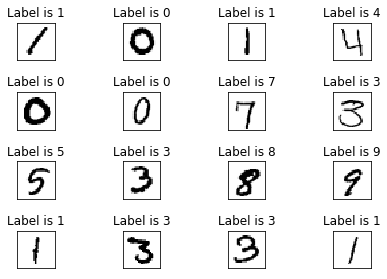

In [11]:
plot_slice(data[0:16])

### Split the whole dataset in features and labels


In [12]:
features = data.drop(['label'], axis='columns', inplace=False)
features.shape

(42000, 784)

In [13]:
labels = data['label']
labels.shape

(42000,)

In [14]:
labels.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

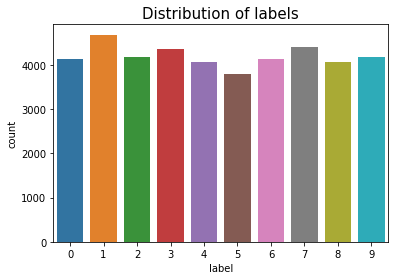

In [15]:
sns.countplot(labels)
plt.title("Distribution of labels", size = 15);

The labels are more or less evenly distributed and represented by a similar number of observations . There are not great disproportions. We can use the accuracy metrics.

### Metrics to measure the model performance
While there are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc), we are going to keep this simple and use **accuracy** as our metric. Accuracy is suitable in this case because the different classes are more or less of similar size and appear to be well balanced. Accuracy is also used in the Kaggle competition, thus we will be able to compare our scores with the other competitors.
We will also show the confusion matrix for the actual vs predicted labels and the classification report.

### Dimensionality reduction
Usually dimensionality reduction is used for three main reasons: 

* help visualize high dimensional data and discover some structures or patterns
* select good features and avoid high correlation between some of the features which leads to the next reason -
* train models efficiently - lower dimensions and less features translate into shorter training times

In this case we will use it to reduce the number of features in order to shorten the training time of the algorithms.

#### PCA (Principal Components Analysis)
PCA is a linear dimension reduction technique that seeks to maximize variance. PCA is affected by scale so we need to scale the features in our data before applying PCA. We are going to use the `MinMaxScaler`. We aim to preserve big part of the variance and at the same time reduce the features. When we later evaluate the models we can return to this step and change the balance between preserved variance and features. 

As a beginning we decide to preserve the variance to 90% and see the resulting reduction of features. Later we will get back to this step and will test the chosen algorithm at different combinations of explained variance and components/features.

In [16]:
scaler = MinMaxScaler().fit(features)

In [17]:
features_scaled = scaler.transform(features)

In [18]:
pca_features = PCA(0.90).fit(features_scaled)

In [19]:
features_scaled_pca = pca_features.transform(features_scaled)

In [20]:
pca_features.n_components_

87

In [21]:
explained_variance = pca_features.explained_variance_ratio_.sum()

In [22]:
explained_variance

0.9005709788011418

 We can see that 90% of the variance has been preserved and the dimensions have been reduced to 87. We reduced the features by a factor of 9.


### Split data to training and test set
We split the features set on which we have just performed scaling and PCA to 70% training and 30% test. We split the features simultaneously with the labels.  

In [23]:
X_tr, X_ts, y_tr, y_ts = train_test_split(features_scaled_pca, labels, test_size = 0.30)

In [24]:
print("Shape of training features: "+str(X_tr.shape))
print("Shape of testing features: "+str(X_ts.shape))
print("-------------------------------------------")
print("Shape of training labels: "+str(y_tr.shape))
print("Shape of testing labels: "+str(y_ts.shape))

Shape of training features: (29400, 87)
Shape of testing features: (12600, 87)
-------------------------------------------
Shape of training labels: (29400,)
Shape of testing labels: (12600,)


The training and testing features and labels appear to have the correct shape.

We will save the current testing dataset so that we can preserve it exactly the same for future use when we test the score for the saved models that have been trained with the current split of training data. [1](#note)

In [25]:
test_set = {"X":X_ts, "y":y_ts}
dump(test_set,"test_set-BACKUP.sav")

['test_set.sav']

In [25]:
# Important 
# Uncomment this if you want to use the original test dataset 
# together with the already saved models that were trained with the same split
# test_set_loaded = load('test_set-BACKUP.sav')
# X_ts = test_set_loaded["X"]
# y_ts = test_set_loaded["y"]

### Algorithm selection
Using cross validation with 5 folds on the training set with 'accuracy' as metrics we will select the three best performing algorithms. We will run them with their default settings.The 7 candidates are:

* Logistic Regression
* K-Nearest Neighbor
* Decision Tree
* AdaBoost
* Random Forrest
* Linear SVC
* Gaussian SVC

In [26]:
k_fold = KFold(n_splits = 5)

In [28]:
# this takes about 10 minutes

results = []
names = []
scoring = 'accuracy'
algorithms = []
algorithms.append(("LR", LogisticRegression()))
algorithms.append(("KNN", KNeighborsClassifier()))
algorithms.append(("CART", DecisionTreeClassifier()))
algorithms.append(("AdaBoost", AdaBoostClassifier()))
algorithms.append(("RandomForrest", RandomForestClassifier()))
algorithms.append(("LinearSVC", LinearSVC()))
algorithms.append(("GaussianSVM", SVC()))
for name, algorithm in algorithms:
    t0=time()   
    cv_results = cross_val_score(algorithm, X_tr, y_tr, cv= k_fold, scoring = scoring)
    t1 = time() - t0
    results.append(cv_results)
    names.append(name)
    print("{0}: mean accuracy {1:.3%} - standard deviation {2:.4} - time {3:n}".format(name, cv_results.mean(), cv_results.std(), t1))

LR: mean accuracy 90.456% - standard deviation 0.003349 - time 64.0924
KNN: mean accuracy 96.687% - standard deviation 0.001597 - time 131.729
CART: mean accuracy 80.136% - standard deviation 0.001483 - time 29.397
AdaBoost: mean accuracy 64.748% - standard deviation 0.02706 - time 100.037
RandomForrest: mean accuracy 88.534% - standard deviation 0.005505 - time 14.2353
LinearSVC: mean accuracy 90.384% - standard deviation 0.003445 - time 130.893
GaussianSVM: mean accuracy 97.007% - standard deviation 0.0008672 - time 99.7147


Now that the base scores are ready lets us plot them on the graph

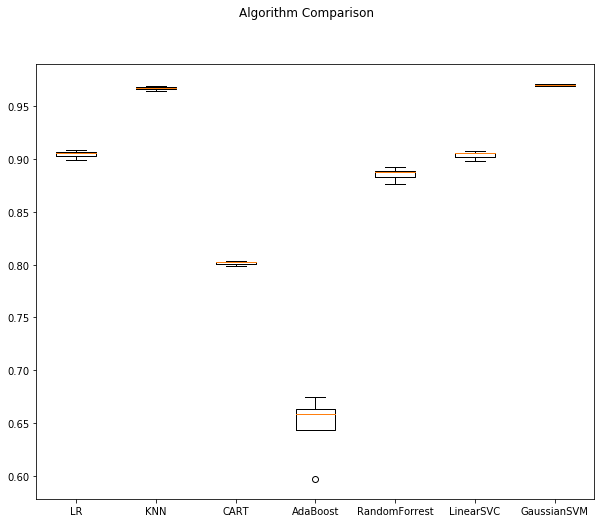

In [29]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The best performing algorithms on our dataset in terms of accuracy are the Gaussian SVM (**97%**), the K-Nearest Neighbors (**96.7%**) and the Logistic Regression (**90.5%**). The LinearSVC (**90.4%**) is not very far behind the LR but we need to draw the line somewhere. We will now try to fine tune the LR, SVM and the KNN.

### Model improvement
We select the Gaussian SVM, KNN and the Logisitc Regression for further fine tuning and improvement. We will use grid search on a number of parameters and again 5 fold cross validation.  
We start with the Logisitic Regression.

### Logistics Regression

In [27]:
# this is the list where we collect the fine tuned models
models = []

In [31]:
# THIS GRID SEARCH TAKES ABOUT 10 MINUTES.
# IF YOU CANNOT WAIT PLEASE LOAD THE MODEL FROM THE DISC FROM THE NEXT CELL

# HOWEVER, IF YOU WANT TO DO THE GRID SEARCH AGAIN PLEASE UNCOMMENT THE CODE BELOW

# model = LogisticRegression()
# parameters_grid = [{
#     "C": [ 1, 10, 100, 1000, 10000],
#     "solver": ['lbfgs','liblinear']
# }]
# model_fit = fit_model(model, parameters_grid, k_fold)


In [125]:
# IF YOU HAVE DECIDED TO DO THE GRID SEARCH AGAIN AND HAVE UNCOMMENTED THE CELL ABOVE
# PLEASE COMMENT THIS BECAUSE IT WILL OVERWRITE THE FITTED MODEL FROM ABOVE

#model_fit = load("LogisticRegression-BACKUP.sav")

In [126]:
model_fit

{'model': 'LogisticRegression',
 'number_of_observations_training': 29400,
 'number_features_training': 87,
 'explained_variance_after_pca': 0.9005709788011418,
 'best_estimator': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
           verbose=0, warm_start=False),
 'best_params': {'C': 100, 'solver': 'lbfgs'},
 'best_score': 0.9054761904761904,
 'time_sec': 402.58581829071045,
 'test_score': 0.9127777777777778}

In [127]:
print("Mean cross-validated score of the best_estimator {0:.3%}".format(model_fit["best_score"]))

Mean cross-validated score of the best_estimator 90.548%


Well, the cross validation score did not increase that much. Now let us see the score of the model with the test dataset.

In [31]:
best_model = model_fit['best_estimator']
score = best_model.score(X_ts, y_ts)
print("Test score {0:.3%}".format(score))

Test score 91.278%


The test score is better on data never seen before which means that the model generalizes well. We will add the test score to our model dictionary where we keep information about the models.

In [32]:
model_fit["test_score"] = score

Lets us take a look at the confusion matrix to see how the classification occurred.

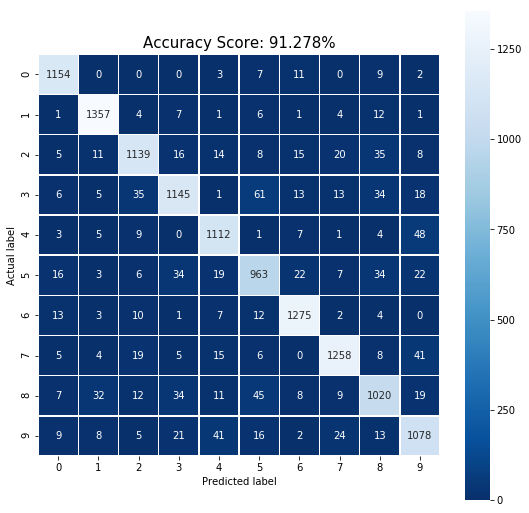

In [33]:
predictions = best_model.predict(X_ts)
draw_confusion_marix(y_ts, predictions, score)

In [34]:
print(classification_report(y_ts, predictions))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96      1186
          1       0.95      0.97      0.96      1394
          2       0.92      0.90      0.91      1271
          3       0.91      0.86      0.88      1331
          4       0.91      0.93      0.92      1190
          5       0.86      0.86      0.86      1126
          6       0.94      0.96      0.95      1327
          7       0.94      0.92      0.93      1361
          8       0.87      0.85      0.86      1197
          9       0.87      0.89      0.88      1217

avg / total       0.91      0.91      0.91     12600



In [35]:
# saving the model in th current directory and saving an excel file with the fined tuned model parameters
persist_data(models, model_fit)

### Gaussian SVM

We are now going to fine tune our Gaussian SVM. According to this site http://yann.lecun.com/exdb/mnist/index.html, the best error for Gaussian SVM is 1.4%. That is we are aiming to reach accuracy of 98.6%. After fine tunnig our model we have reached accuracy 98.19%. We are not there yet but we are pretty close.

In [40]:
# THIS GRID SEARCH TAKES ABOUT 50 MINUTES.
# IF YOU CANNOT WAIT PLEASE LOAD THE MODEL FROM THE DISC FROM THE NEXT CELL

# HOWEVER, IF YOU WANT TO DO THE GRID SEARCH AGAIN PLEASE UNCOMMENT THE CODE BELOW

# model = SVC(cache_size=1000)
# parameters_grid = [{
#     "C": [5, 10, 20],
#     "gamma": [0.01, 0.05, 0.1]
# }]
# model_fit = fit_model(model, parameters_grid, k_fold)

In [128]:
# IF YOU HAVE DECIDED TO DO THE GRID SEARCH AGAIN AND HAVE UNCOMMENTED THE CELL ABOVE
# PLEASE COMMENT THIS BECAUSE IT WILL OVERWRITE THE FITTED MODEL FROM ABOVE

#model_fit = load("SVC-BACKUP.sav")

In [129]:
model_fit

{'model': 'SVC',
 'number_of_observations_training': 29400,
 'number_features_training': 87,
 'explained_variance_after_pca': 0.9005709788011418,
 'best_estimator': SVC(C=5, cache_size=1000, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'best_params': {'C': 5, 'gamma': 0.05},
 'best_score': 0.981326530612245,
 'time_sec': 4048.7535219192505,
 'test_score': 0.981904761904762}

In [130]:
print("Mean cross-validated score of the best_estimator {0:.3%}".format(model_fit["best_score"]))

Mean cross-validated score of the best_estimator 98.133%


Well, it took almost an hour to grid search and fit the model. The best validation score has improved compared to the cross validation score from the model selection part.

Now let us see the score of the model with the test dataset.

In [39]:
best_model = model_fit['best_estimator']
score = best_model.score(X_ts, y_ts)
print("Test score {0:.3%}".format(score))

Test score 98.190%


We will add the test score to our model dictionary where we keep information about the models.

In [40]:
model_fit["test_score"] = score

Lets us take a look at the confusion matrix to see how the classification occurred.

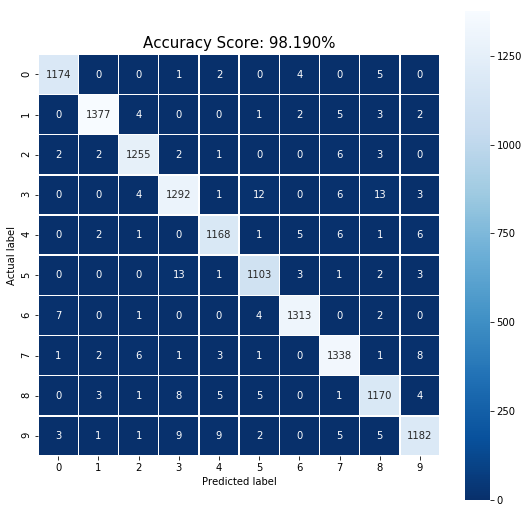

In [41]:
predictions = best_model.predict(X_ts)
draw_confusion_marix(y_ts, predictions, score)

In [42]:
print(classification_report(y_ts, predictions))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1186
          1       0.99      0.99      0.99      1394
          2       0.99      0.99      0.99      1271
          3       0.97      0.97      0.97      1331
          4       0.98      0.98      0.98      1190
          5       0.98      0.98      0.98      1126
          6       0.99      0.99      0.99      1327
          7       0.98      0.98      0.98      1361
          8       0.97      0.98      0.97      1197
          9       0.98      0.97      0.97      1217

avg / total       0.98      0.98      0.98     12600



In [43]:
# saving the model in the current directory and saving an excel file with the fined tuned model parameters
persist_data(models, model_fit)

### K Nearest Neihbors

Last but not least we will try to improve the K-Nearest Neighbors algorithm.

In [49]:
# THIS GRID SEARCH TAKES ABOUT 10 MINUTES.
# IF YOU CANNOT WAIT PLEASE LOAD THE MODEL FROM THE DISC FROM THE NEXT CELL

# HOWEVER, IF YOU WANT TO DO THE GRID SEARCH AGAIN PLEASE UNCOMMENT THE CODE BELOW

# model = KNeighborsClassifier()
# k = np.arange(3,10,2)

# parameters_grid = [{
#     'n_neighbors':k
# }]

# model_fit = fit_model(model, parameters_grid, k_fold)

In [131]:
# IF YOU HAVE DECIDED TO DO THE GRID SEARCH AGAIN AND HAVE UNCOMMENTED THE CELL ABOVE
# PLEASE COMMENT THIS BECAUSE IT WILL OVERWRITE THE FITTED MODEL FROM ABOVE

model_fit = load("KNeighborsClassifier-BACKUP.sav")

In [132]:
model_fit

{'model': 'KNeighborsClassifier',
 'number_of_observations_training': 29400,
 'number_features_training': 87,
 'explained_variance_after_pca': 0.9005709788011418,
 'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=3, p=2,
            weights='uniform'),
 'best_params': {'n_neighbors': 3},
 'best_score': 0.9672789115646259,
 'time_sec': 2179.005108356476,
 'test_score': 0.9705555555555555}

In [133]:
print("Mean cross-validated score of the best_estimator {0:.3%}".format(model_fit["best_score"]))

Mean cross-validated score of the best_estimator 96.728%


Now let us see the score of the model with the test dataset.

In [47]:
best_model = model_fit['best_estimator']
score = best_model.score(X_ts, y_ts)
print("Test score {0:.3%}".format(score))

Test score 97.056%


Below we add the test score to the dictionary with the models.

In [48]:
model_fit["test_score"] = score

Lets us take a look at the confusion matrix to see how the classification occurred.

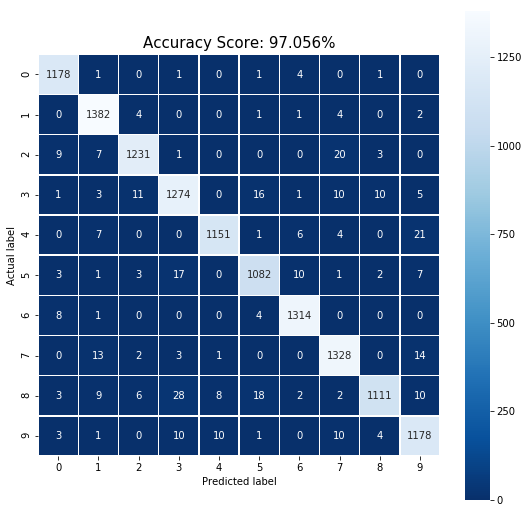

In [49]:
predictions = best_model.predict(X_ts)
draw_confusion_marix(y_ts, predictions, score)

In [50]:
print(classification_report(y_ts, predictions))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1186
          1       0.97      0.99      0.98      1394
          2       0.98      0.97      0.97      1271
          3       0.96      0.96      0.96      1331
          4       0.98      0.97      0.98      1190
          5       0.96      0.96      0.96      1126
          6       0.98      0.99      0.99      1327
          7       0.96      0.98      0.97      1361
          8       0.98      0.93      0.95      1197
          9       0.95      0.97      0.96      1217

avg / total       0.97      0.97      0.97     12600



In [51]:
# saving the model in th current directory and saving an excel file with the fined tuned model parameters
persist_data(models, model_fit)

### Best models comparison

In [52]:
print("SUMMARY:")
print("-------------")
for model in models:
    
    print("{0} - test score {1:.2%} - features {2} - observations {3} - grid search time {4:n}s"
          .format(model["model"], model["test_score"], model["number_features_training"], model["number_of_observations_training"], model["time_sec"]))

SUMMARY:
-------------
LogisticRegression - test score 91.28% - features 87 - observations 29400 - grid search time 402.586s
SVC - test score 98.19% - features 87 - observations 29400 - grid search time 4048.75s
KNeighborsClassifier - test score 97.06% - features 87 - observations 29400 - grid search time 2179.01s


The best model for our dataset is the Gaussian SVM with a score from the test set of 98% but it took 1 hour to be trained. On the other hand the K-Nearest Neighbors scored very close 97% but it took only 30
minutes to train. The Logistic Regression is far behind. I would look for further improvements of the KNN and the SVM models.

### Further improvements with feature selections

 Now that we have chosen the best models and have performed grid search we can look for other ways to improve our models. We go back to the PCA step and try to improve the models by grid search with different numbers of features. We have arbitrarily chosen to retain 90% of the variance thus getting 87 features. We can now test the SVM and KNN models with fewer and also a bit more features.
 
 For example, we can perform  PCA aiming for explained variance of 60%, 70%, 80% and 95%. Thus, we will get 5 sets of features. We can again run the grid search for the SVM and KNN and evaluate their scores. 
 
 We will rerun the KNN because it takes less time. But the procedure to rerun SVM will be the same.

In [93]:
k = np.arange(3,8,2)
models_features = [] # a collection with the fine tuned models
model = None
expl_vars = [0.60, 0.70, 0.80, 0.90, 0.95] # target explained variance levels

algorithms = [] # a collection with the models that we will evaluate

# algorithms.append((LogisticRegression(), [{
#      "C": [ 1, 10, 100, 1000, 10000],
#      "solver": ['lbfgs','liblinear']
#  }] ))

algorithms.append((KNeighborsClassifier(), [{
    'n_neighbors':k
}]))

# algorithms.append((SVC(),[{
#     "C": [5, 10, 20],
#     "gamma": [0.01, 0.05, 0.1]
# }])) # we will not process this because it takes too much time

In [94]:
algorithms

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'), [{'n_neighbors': array([3, 5, 7])}])]

In [86]:
# WARNING !!! This takes a lot of time 

# You can load the data from the file in the next cell 

# Performing PCA to select different sets of features for 5 target explained variance levels

# for variance in expl_vars:
    
#     print("Performing PCA ...")
    
#     pca_features = PCA(variance).fit(features_scaled)
    
#     features_scaled_pca = pca_features.transform(features_scaled)
    
#     explained_variance = pca_features.explained_variance_ratio_.sum()
    
#     components = pca_features.n_components_
    
#     print("Explained variance {0:.2%} with {1} components".format(explained_variance, components))
    
#     print("Splitting training and test set...")
    
#     X_tr, X_ts, y_tr, y_ts = train_test_split(features_scaled_pca, labels, test_size = 0.30)    
    
#     print()
    
#     for algorithm, parameters_grid in algorithms:
        
#         print("Performing Grid Search on: {0} with {1} features and explained variance {2:.1%}".format(algorithm.__class__.__name__, components,  explained_variance))       
        
#         model = algorithm      
        
#         model = fit_model(model, parameters_grid, k_fold)
        
#         best_model = model['best_estimator']
        
#         score = best_model.score(X_ts, y_ts)
        
#         model["test_score"] = score
        
#         print("Ready")
        
#         print("{0} - best score {1:.2%} - test score {2:.2%} - grid search time {3:n}s"
#           .format(model["model"], model["best_score"], model["test_score"], model["time_sec"]))
        
#         models_features.append(model)          
        
#         print()
# dump(models_features,"models_features.sav")


Performing PCA ...
Explained variance 60.85% with 17 components
Splitting training and test set...

Performing Grid Search on: KNeighborsClassifier with 17 features and explained variance 60.9%
Ready
KNeighborsClassifier - best score 95.64% - test score 96.23% - grid search time 136.212s

Performing PCA ...
Explained variance 70.17% with 26 components
Splitting training and test set...

Performing Grid Search on: KNeighborsClassifier with 26 features and explained variance 70.2%
Ready
KNeighborsClassifier - best score 96.79% - test score 97.06% - grid search time 299.839s

Performing PCA ...
Explained variance 80.03% with 43 components
Splitting training and test set...

Performing Grid Search on: KNeighborsClassifier with 43 features and explained variance 80.0%
Ready
KNeighborsClassifier - best score 97.16% - test score 96.90% - grid search time 681.057s

Performing PCA ...
Explained variance 90.06% with 87 components
Splitting training and test set...

Performing Grid Search on: KNe

['models_features.sav']

In [99]:
# You can load the models here. Please uncomment and run
#models_features = load('models_features.sav')

In [114]:
training_scores = []
testing_scores =[]
features = []
for m in models_features:
    training_scores.append(m["best_score"])
    testing_scores.append(m["test_score"])
    features.append(m["number_features_training"])
    print("Features: {0} -- Cross validated accuracy {1:.2%} -- Test accuracy {2:.2%}".format(m["number_features_training"], m["best_score"], m["test_score"]))

Features: 17 -- Cross validated accuracy 95.64% -- Test accuracy 96.23%
Features: 26 -- Cross validated accuracy 96.79% -- Test accuracy 97.06%
Features: 43 -- Cross validated accuracy 97.16% -- Test accuracy 96.90%
Features: 87 -- Cross validated accuracy 96.76% -- Test accuracy 96.90%
Features: 154 -- Cross validated accuracy 96.48% -- Test accuracy 96.58%


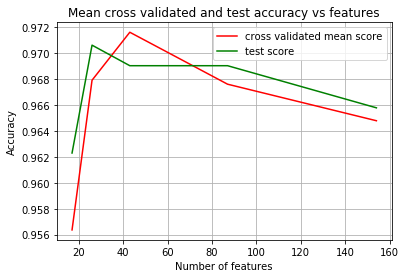

In [116]:
plt.plot(features,training_scores, "red", label = "cross validated mean score")
plt.plot(features,testing_scores, "green", label = "test score")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Mean cross validated and test accuracy vs features")
plt.grid(True)
plt.legend()
plt.show()

We see that there is no point in increasing the features above 26 for the KNN model. If we keep the number of features 26 which corresponds to explained variance of 70% we are able to achieve test accuracy of 97%. Increasing the number of features above 26 does not bring any benefits and may lead to overfitting. 


<a id='note'></a>
### Important remark
**I have now re-run the whole notebook using the already trained and saved models (loading them from the respective files) and have noticed that the accuracy has improved. The reason for this is that with each run of the notebook there is a new split of the features to training and testing sets.   Each new testing set may contain  some data on which the models have already been trained. Thus, the accuracy increases artificially because the model has already seen some of the testing data. The most reliable way to evaluate the accuracy is to test the models right after the training when the training and the test sets are still well separated or to record the testing set on file. When loading the models from files they should be tested with the same test set that was set apart from the training set on which they had been trained.**

### Useful links:
1. https://www.kaggle.com/vzocca/simple-mnist-python-code/data
2. https://www.kaggle.com/ddmngml/pca-and-svm-on-mnist-dataset/data
3. https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
4.https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
5. Machine Learning Mastery with Python, Jason Brownlee  